# Getting started with Task 3

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%%shell
#!/bin/bash

# Download all the components of the dataset from https://library.ucsd.edu/dc/object/bb29449106
# and put them in the directory intracardiac_dataset

# Make the directory
echo "Making directory intracardiac_dataset"
mkdir -p intracardiac_dataset
echo "Done"

# Move into the directory
cd intracardiac_dataset

# Download the first element (README.md)
echo "Downloading the dataset - This may take a while"
wget https://library.ucsd.edu/dc/object/bb29449106/_1_1.md/download -O README.md
for i in {2..22}
do
    wget https://library.ucsd.edu/dc/object/bb29449106/_${i}_1.tgz/download
    echo "Unzipping the file"
    tar -xvzf download
    rm -f download
done
echo "Done"

# Return to the parent directory
cd -

IndentationError: unexpected indent (2743421516.py, line 19)

Download the dataset from the [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) using the script `download_intracardiac_dataset.sh`:

```bash
source download_intracardiac_dataset.sh
```

## Load Modules and Preprocessing Functions

Load modules and preprocessing functions.

In [3]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from typing import List

Load the `cardiac_ml_tools` module.

In [5]:
%run cardiac_ml_tools.py

## Load the dataset

In [6]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))


Number of file pairs: 16117
Example of file pair:
intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_3_bcl_I/pECGData_hearts_dd_0p2_geo_inn_act_3_bcl_I_bcl.1000.innerindex.0.volunteer.v1.npy
intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_3_bcl_I/VmData_hearts_dd_0p2_geo_inn_act_3_bcl_I_bcl.1000.innerindex.0.volunteer.v1.npy


## Dataset details

The dataset [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106)
consists of pairs of computationally simulated intracardiac transmembrane voltage recordings and ECG signals.
In total, 16140 organ-level simulations were conducted to create this dataset.
Simulations were performed using Lassen supercomputer at Lawrence Livermore National Lab (LLNL), concurrently utilizing 4 GPUs and 40 CPU cores.
Each simulation produced pairs of 500ms-by-10 raw electrode signals and 500ms-by-75 transmembrane voltage signals.
For convenience, we collect those signals in matrices and give them the following names:

Tensor | Description | Shape | Notes
--- | --- | --- | ---
$X$ | Row electrode signals | $10 \times 500$ | 10-lead ECG signals from the simulated torso (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$V$ | Activation map | $75 \times 500$ | Transmembrane voltage signals from the simulated heart (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$E$ | 12-lead ECG signals | $12 \times 500$ | 12-lead ECG signals obtained by `get_standard_leads`($X$)
$A$ | Activation map | $75 \times 1$ | Activation time, defined as $A_i = \text{min}_j(V_{ij})$

**IMPORTANT** : The raw data in the dataset consists of 10-lead ECG signals and 75-lead transmembrane voltage signals. The 12-lead ECG signals are obtained from the 10-lead ECG signals using the function `get_standard_leads` (in the file `cardiac_ml_tools.py`).

The overall generation process is shown in the following image. The ECG signal is recorded using 10 virtual electrodes and the transmembrane voltages are recorded at 75 points within the myocardium. The transmembrane voltages are then used to generate the spatio-temporal activation maps.

![ECG 10 2 12](../figures/data_generation.png)

## Getting the standard 12-lead ECG from the 10-lead ECG

The function `get_standard_leads` (in the file `cardiac_ml_tools.py`) is used to obtain the 12-lead ECG signals from the 10-lead ECG signals. It implements the following transformation, where the (Wilson Lead) is defined as $Vw = 1/3*(RA + LA + LL)$:
$$
\left\{
\begin{array}{lll}
    X_{:,1}  & \to  & RA \\
    X_{:,2}  & \to  & LA \\
    X_{:,3}  & \to  & LL \\
    X_{:,4}  & \to  & RL \\
    X_{:,5}  & \to  & V1 \\
    X_{:,6}  & \to  & V2 \\
    X_{:,7}  & \to  & V3 \\
    X_{:,8}  & \to  & V4 \\
    X_{:,9}  & \to  & V5 \\
    X_{:,10} & \to &  V6 \\
\end{array}
\right.
\text{        and        }
\left\{
\begin{array}{lll}          
\text{Lead } I& : & LA - RA \\
\text{Lead } II& : & LL - RA \\
\text{Lead } III& : & LL - LA \\
\text{Lead } aVR& : &  \frac{3}{2} (RA - Vw) \\
\text{Lead } aVL& : &  \frac{3}{2} (LA - Vw) \\
\text{Lead } aVF& : &  \frac{3}{2} (LL - Vw)\\
\text{Lead } V1 & : & V1 - Vw \\
\text{Lead } V2 & : & V2 - Vw \\
\text{Lead } V3 & : & V3 - Vw \\
\text{Lead } V4 & : & V4 - Vw \\
\text{Lead } V5 & : & V5 - Vw \\
\text{Lead } V6 & : & V6 - Vw \\
\end{array}
\right.
$$

Case 16116 : intracardiac_dataset/data_hearts_dd_0p2_geo_act_2_bcl/pECGData_hearts_dd_0p2_geo_act_2_bcl_bcl.600.pattern.9.volunteer.v9.npy


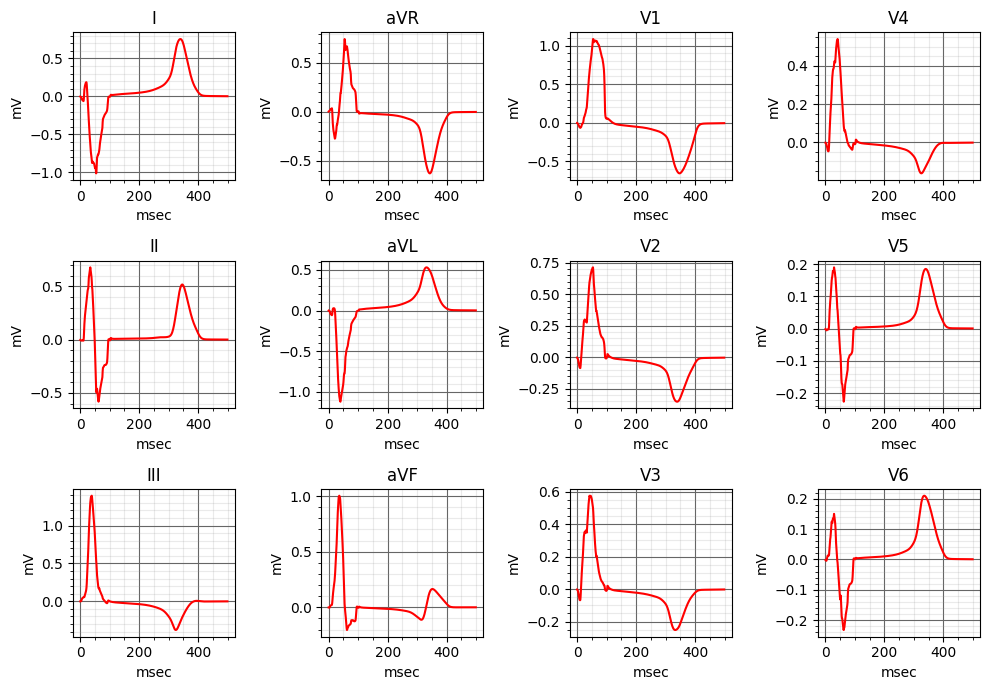

In [30]:
# Example of file pair
case = 16116
# ECG plot
row = 3
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

# create a figure with 12 subplots
for i in range(pECGData.shape[1]):
    plt.subplot(row, column, reorder[i + 1])
    plt.plot(pECGData[0:num_timesteps,i],'r')
    plt.title(titles[i])
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

## Getting the activation map from the transmembrane voltages

The funtion `get_activation_map` (in the file `cardiac_ml_tools.py`) is used to obtain the activation map from the transmembrane voltages. It implements the following transformation $A_i = \text{min}_j(V_{ij})$.

Case 213 : intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_3_bcl_I/pECGData_hearts_dd_0p2_geo_inn_act_3_bcl_I_bcl.1000.innerindex.24.volunteer.v8.npy


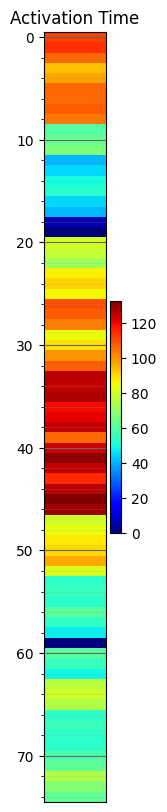

In [ ]:
# Example of file pair
case = 213
plt.figure(figsize=(1, 10))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

ActTime = get_activation_time(VmData)

# plot the Activation Time array
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('Activation Time')
plt.colorbar()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
# not xticks
plt.xticks([])
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()


## Task 3: Learning the mapping from the 12-lead ECG to the activation map

Case 213 : intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_3_bcl_I/pECGData_hearts_dd_0p2_geo_inn_act_3_bcl_I_bcl.1000.innerindex.24.volunteer.v8.npy
Case 213 : intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_3_bcl_I/pECGData_hearts_dd_0p2_geo_inn_act_3_bcl_I_bcl.1000.innerindex.24.volunteer.v8.npy


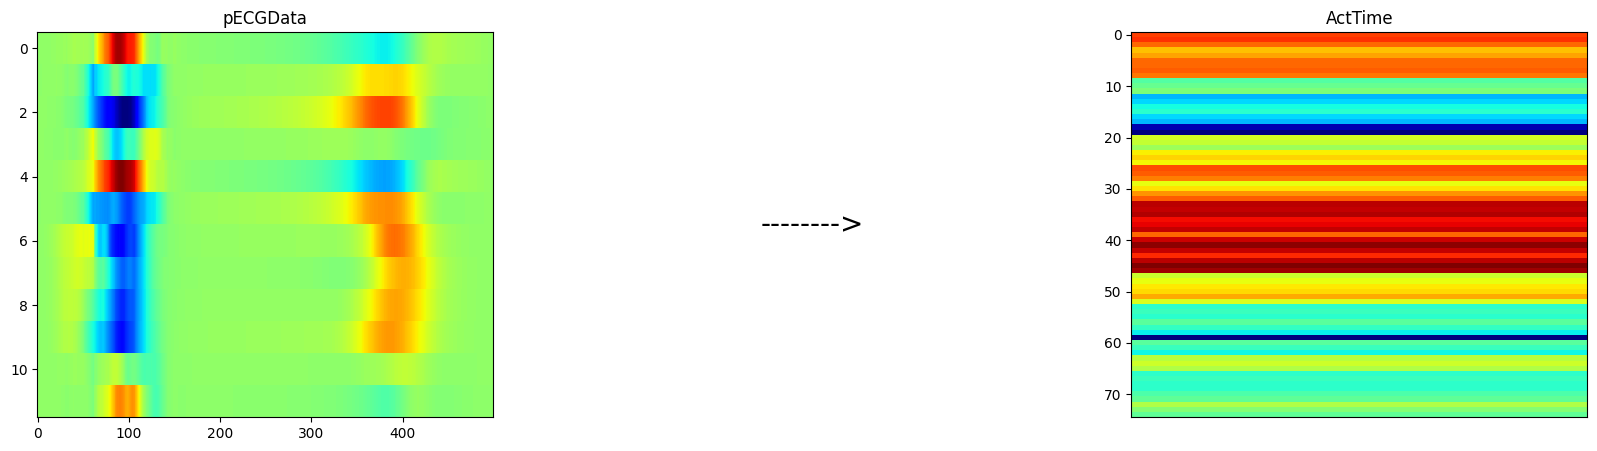

In [17]:
# make a plot with the "pECGData" -> "ActTime"
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])
ActTime = get_activation_time(VmData)

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print an arrow
plt.text(0.5, 0.5, '-------->', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off')
plt.subplot(row, column, 3)
# plot ActTime
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
plt.xticks([])
plt.title('ActTime')
plt.show()
plt.close()

In [53]:
X = []
y = []
for i in range(len(file_pairs)):
  temp = np.load(file_pairs[i][0])
  temp1 = np.load(file_pairs[i][1])
  temp = get_standard_leads(temp)
  temp1 = get_activation_time(temp1)
  X.append(temp)
  y.append(temp1)

In [51]:
#X[16116]
#y[16116]

array([[-0.00268038, -0.00320762, -0.00052724, ..., -0.00195406,
        -0.00149606, -0.00165456],
       [-0.00600421, -0.0047307 ,  0.00127351, ..., -0.00250362,
        -0.00237178, -0.00259691],
       [-0.00783657, -0.00672833,  0.00110824, ..., -0.00501209,
        -0.00376986, -0.00379119],
       ...,
       [ 0.00169377,  0.00045646, -0.00123731, ..., -0.00164234,
         0.0002934 ,  0.00060367],
       [ 0.00166208,  0.00044219, -0.00121989, ..., -0.00162827,
         0.00028706,  0.00059447],
       [ 0.00163074,  0.00042802, -0.00120271, ..., -0.00161433,
         0.00028077,  0.00058534]])

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=8)

In [76]:
X_train = np.array(X_train)
X_train.shape

(13699, 500, 12)

In [77]:
X_test = np.array(X_test)
X_test.shape

(2418, 500, 12)

In [80]:
y_train = np.array(y_train)
y_train.shape

(13699, 75, 1)

In [79]:
y_test = np.array(y_test)
y_test.shape

(2418, 75, 1)

In [83]:
y_test[1]

array([[110],
       [112],
       [103],
       [ 61],
       [ 65],
       [ 70],
       [ 89],
       [ 92],
       [ 97],
       [ 55],
       [ 59],
       [ 56],
       [ 64],
       [111],
       [114],
       [112],
       [ 76],
       [ 68],
       [ 95],
       [ 90],
       [ 83],
       [ 55],
       [ 60],
       [ 65],
       [ 78],
       [ 84],
       [ 89],
       [  6],
       [ 24],
       [  0],
       [ 46],
       [ 40],
       [ 37],
       [ 65],
       [ 67],
       [ 66],
       [ 81],
       [ 73],
       [ 61],
       [ 90],
       [ 95],
       [124],
       [ 92],
       [124],
       [117],
       [101],
       [142],
       [133],
       [130],
       [108],
       [110],
       [ 88],
       [ 93],
       [ 97],
       [101],
       [108],
       [113],
       [114],
       [111],
       [102],
       [108],
       [ 50],
       [ 58],
       [ 52],
       [103],
       [100],
       [ 51],
       [ 45],
       [ 40],
       [ 96],
       [ 92],
      

In [102]:
input_shape = [X_train.shape]
input_shape
input_shape[0][1]

500

In [1]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(3,3), activation='relu', input_shape=(input_shape[0][0],input_shape[0][1], input_shape[0][2])),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

NameError: ignored

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=20)

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

# Tricks

- As in many machine learning problems, normalization of the data might be helpful or even necessary. Different normalization schemes might be applied.